In [ ]:
from google.colab import drive

drive.mount("/content/drive");

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/BraTS Dataset/brats_subset.zip' -d '/content/dataset'

In [ ]:
import os
import nibabel as nib
from glob import glob
from pathlib import Path
from pprint import pprint
from torch.utils.data import Dataset, DataLoader, random_split
import torch as pt
import numpy as np

class NormalizePatientDataset:
    def __call__(self, patient_mri_scan):
        modalities = patient_mri_scan['modalities']

        mean = modalities.mean()
        std = modalities.std()
        if std == 0:
            std = 1.0

        patient_mri_scan['modalities'] = (modalities - mean) / std
        return patient_mri_scan


class PatientDataset(Dataset):
    def __init__(self, dataset_path='/content/dataset', transform = None):
        self.dataset_path = dataset_path
        self.patients = os.listdir(self.dataset_path)
        self.patients_mri_scans = []
        self.transform = transform
        self._load_dataset()

    def _load_dataset(self):
        for patient in self.patients:
            patient_path = os.path.join(self.dataset_path, patient)

            segments = glob(os.path.join(patient_path, "*-seg.nii"))
            modalities = glob(os.path.join(patient_path, "*-t*.nii"))

            patient_mri_scans = {
                "patient_id": patient,
                "segments": segments,
                "modalities": modalities
            }

            self.patients_mri_scans.append(patient_mri_scans)

        return self.patients_mri_scans

    def load_nib_scans(self, patient_mri_scans):

                segments = [nib.load(segment).get_fdata() for segment in patient_mri_scans["segments"]]
                modalities = [nib.load(modality).get_fdata() for modality in patient_mri_scans["modalities"]]

                loaded_patient_mri_scan = {
                    "patient_id": patient_mri_scans['patient_id'],
                    "segments": pt.tensor(np.array(segments)),
                    "modalities": pt.tensor(np.array(modalities))
                }

                return loaded_patient_mri_scan


    def __len__ (self):
        return len(self.patients_mri_scans)

    def __getitem__(self, i):
        patient_mri_scans = self.patients_mri_scans[i]
        _loaded_patient_mri_scans =  self.load_nib_scans(patient_mri_scans)

        if(self.transform):
              return self.transform(_loaded_patient_mri_scans)

        return  _loaded_patient_mri_scans

In [ ]:
dataset = PatientDataset(transform=NormalizePatientDataset())

train_size = int(len(dataset) * 0.8)
test_size = int(len(dataset) * 0.2)

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

for batch in train_loader:
    print(batch['modalities'][0])
    break;

tensor([[[[-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          ...,
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675]],

         [[-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          ...,
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675]],

         [[-0.3675, -0.3675, -0.3675,  ..., -0.3675, -0.3675, -0.3675],
          [-0.3675, -0.3675, -

In [1]:
import os
import glob
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# -------------------------------
# Config
# -------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_DIR = "/content/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Training hyperparams
NUM_EPOCHS = 50
BATCH_SIZE = 1
LR = 1e-3
WEIGHT_DECAY = 1e-5
SAVE_EVERY_BATCHES = 5
GRAD_CLIP = 1.0
VAL_SPLIT = 0.2
PATIENCE = 8

# -------------------------------
# Model (same as yours)
# -------------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UpConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(out_ch * 2, out_ch)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX//2,
                                    diffY // 2, diffY - diffY//2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.ReLU(),
            nn.Linear(mlp_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x shape: (seq_len, batch, embed_dim)
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        mlp_out = self.mlp(x)
        x = self.norm2(x + mlp_out)
        return x

class TransUNet(nn.Module):
    def __init__(self, in_ch=4, out_ch=1, img_size=128, patch_size=8, embed_dim=256, num_heads=4, num_layers=2):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, 64)
        self.enc2 = ConvBlock(64, 128)
        self.pool = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)

        # Transformer bridge
        num_patches = (img_size // patch_size) ** 2
        self.patch_embed = nn.Conv2d(256, embed_dim, kernel_size=patch_size, stride=patch_size)
        # pos_embed shape -> (num_patches, 1, embed_dim) so it can broadcast over batch dimension
        self.pos_embed = nn.Parameter(torch.randn(num_patches, 1, embed_dim))
        self.transformer = nn.ModuleList([TransformerBlock(embed_dim, num_heads, embed_dim * 4) for _ in range(num_layers)])
        self.unpatch = nn.ConvTranspose2d(embed_dim, 256, kernel_size=patch_size, stride=patch_size)

        # Decoder
        self.up1 = UpConv(256, 128)
        self.up2 = UpConv(128, 64)
        self.final = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        # encoder
        e1 = self.enc1(x)                 # (B,64,H,W)
        e2 = self.enc2(self.pool(e1))     # (B,128,H/2,W/2)
        e3 = self.enc3(self.pool(e2))     # (B,256,H/4,W/4)

        # patch -> sequence
        patches = self.patch_embed(e3)    # (B,embed,Hp,Wp)
        B, C, H, W = patches.shape
        seq = patches.flatten(2).permute(2, 0, 1)   # (N, B, C) where N=Hp*Wp

        # add positional embeddings (broadcasting over batch dimension)
        seq = seq + self.pos_embed[:seq.size(0), :, :]

        # transformer
        for blk in self.transformer:
            seq = blk(seq)

        # back to feature map
        x = seq.permute(1, 2, 0).view(B, C, H, W)
        x = self.unpatch(x)

        # decoder
        x = self.up1(x, e2)
        x = self.up2(x, e1)
        out = self.final(x)
        return out

# -------------------------------
# Losses and metrics
# -------------------------------
def dice_coeff_from_logits(logits, target, thr=0.5, eps=1e-6):
    probs = torch.sigmoid(logits)
    pred = (probs > thr).float()
    inter = (pred * target).sum(dim=[1,2,3])
    union = pred.sum(dim=[1,2,3]) + target.sum(dim=[1,2,3])
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

def dice_loss(logits, target, eps=1e-6):
    probs = torch.sigmoid(logits)
    inter = (probs * target).sum(dim=[1,2,3])
    union = probs.sum(dim=[1,2,3]) + target.sum(dim=[1,2,3])
    loss = 1 - ((2*inter + eps) / (union + eps))
    return loss.mean()

def combined_loss(logits, target):
    bce = F.binary_cross_entropy_with_logits(logits, target)
    d = dice_loss(logits, target)
    return bce + d

# -------------------------------
# Build dataset / dataloaders
# -------------------------------
# This expects you have train_dataset (or dataset) in scope (your PatientDataset wrapper).
if 'train_dataset' in globals():
    dataset = train_dataset
elif 'dataset' in globals():
    dataset = dataset
else:
    raise RuntimeError("No dataset found in scope. Ensure `train_dataset` or `dataset` exists.")

total = len(dataset)
val_count = max(1, int(total * VAL_SPLIT))
train_count = total - val_count
train_ds, val_ds = random_split(dataset, [train_count, val_count], generator=torch.Generator().manual_seed(42))

# Use num_workers=0 to avoid multiprocess issues on some environments; increase if you know it works
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Dataset sizes -> total: {total}, train: {train_count}, val: {val_count}")
sample = next(iter(train_loader))
# print only tensor shapes
print("Sample shapes (raw):", {k: v.shape for k,v in sample.items() if isinstance(v, torch.Tensor)})

# -------------------------------
# Create model, optimizer, scheduler, AMP scaler
# -------------------------------
# infer img_size from sample if available (assumes square images)
img_size = sample['modalities'].shape[-1] if isinstance(sample['modalities'], torch.Tensor) else 128
model = TransUNet(in_ch=4, out_ch=1, img_size=img_size).to(DEVICE)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# NOTE: older torch versions do NOT accept verbose argument - omit it
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=PATIENCE)
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=='cuda'))

# Optional resume from checkpoint if exists
ckpts = sorted(glob.glob(os.path.join(CHECKPOINT_DIR, "*.pth")))
start_epoch = 0
best_val_loss = float('inf')
if ckpts:
    latest = ckpts[-1]
    print("Found checkpoint, attempting to load:", latest)
    state = torch.load(latest, map_location=DEVICE)
    if isinstance(state, dict) and 'model_state_dict' in state:
        model.load_state_dict(state['model_state_dict'])
        optimizer.load_state_dict(state.get('optimizer_state_dict', optimizer.state_dict()))
        start_epoch = state.get('epoch', 0)
        best_val_loss = state.get('best_val_loss', best_val_loss)
        print(f"Resumed from checkpoint (epoch={start_epoch}, best_val_loss={best_val_loss})")
    else:
        # fallback: assume it's a raw state_dict
        try:
            model.load_state_dict(state)
            print("Loaded raw state_dict checkpoint")
        except Exception as e:
            print("Warning: failed to load checkpoint:", e)

# -------------------------------
# Training loop
# -------------------------------
for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS} Train")
    batch_counter = 0

    for batch_idx, batch in pbar:
        imgs = batch['modalities'].float().to(DEVICE)
        masks = batch['segments'].float().to(DEVICE)

        # If volumes present (B,C,H,W,D) select center slice
        if imgs.ndim == 5:
            d = imgs.shape[-1]; mid = d // 2
            imgs = imgs[..., mid]; masks = masks[..., mid]

        with torch.cuda.amp.autocast(enabled=(DEVICE.type=='cuda')):
            logits = model(imgs)
            loss = combined_loss(logits, masks)

        scaler.scale(loss).backward()
        # unscale + clip gradients
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        running_loss += loss.item() * imgs.size(0)
        batch_counter += 1
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        # periodic batch checkpoint
        if batch_counter % SAVE_EVERY_BATCHES == 0:
            ckpt = {
                'epoch': epoch + 1,
                'batch': batch_counter,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss
            }
            fname = os.path.join(CHECKPOINT_DIR, f"transunet_ep{epoch+1}_b{batch_counter}.pth")
            torch.save(ckpt, fname)
            print(f"\nSaved intermediate checkpoint -> {fname}")

    epoch_train_loss = running_loss / len(train_loader.dataset)

    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    val_loss = 0.0
    dices = []
    with torch.no_grad():
        for batch in val_loader:
            imgs = batch['modalities'].float().to(DEVICE)
            masks = batch['segments'].float().to(DEVICE)
            if imgs.ndim == 5:
                d = imgs.shape[-1]; mid = d//2
                imgs = imgs[..., mid]; masks = masks[..., mid]
            logits = model(imgs)
            loss = combined_loss(logits, masks)
            val_loss += loss.item() * imgs.size(0)
            dices.append(dice_coeff_from_logits(logits, masks))

    val_loss = val_loss / len(val_loader.dataset)
    mean_dice = float(np.mean(dices)) if dices else 0.0

    print(f"\nEpoch {epoch+1} summary -> train_loss: {epoch_train_loss:.4f}  val_loss: {val_loss:.4f}  val_dice: {mean_dice:.4f}")

    # step scheduler and print LR(s)
    scheduler.step(val_loss)
    for i, pg in enumerate(optimizer.param_groups):
        print(f"LR group {i}: {pg['lr']:.6f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_ckpt = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss
        }
        best_path = os.path.join(CHECKPOINT_DIR, "best_transunet.pth")
        torch.save(best_ckpt, best_path)
        print(f"🌟 New best model saved -> {best_path}")

print("Training finished.")

RuntimeError: No dataset found in scope. Ensure `train_dataset` or `dataset` exists.

✅ Loaded model checkpoint from: /content/drive/MyDrive/checkpoints/transunet_epoch9_batch5.pth
🎯 Dice Score: 0.1777


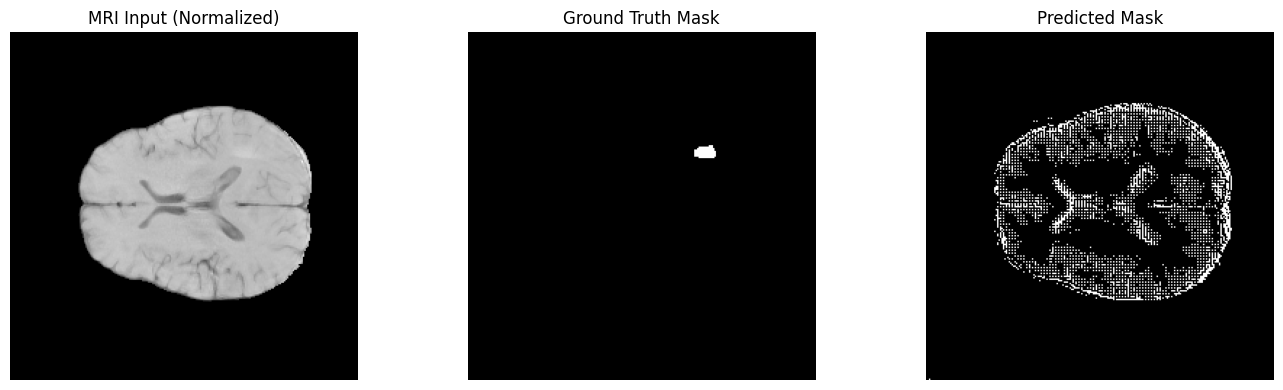

In [ ]:
import matplotlib.pyplot as plt
import torch
import os

# === Load Trained Checkpoint ===
latest_ckpt = sorted(os.listdir(CHECKPOINT_DIR))[-1]
ckpt_path = os.path.join(CHECKPOINT_DIR, latest_ckpt)

model = TransUNet(in_ch=4, out_ch=1).to(device)
state = torch.load(ckpt_path, map_location=device)

# Load properly whether it’s raw dict or wrapped
if "model_state_dict" in state:
    model.load_state_dict(state["model_state_dict"])
else:
    model.load_state_dict(state)
model.eval()

print(f"✅ Loaded model checkpoint from: {ckpt_path}")

# === Dice Score ===
def dice_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    return (2. * inter + smooth) / (pred.sum() + target.sum() + smooth)

# === Evaluate One Batch ===
with torch.no_grad():
    sample = next(iter(test_loader))
    inputs = sample['modalities'].float().to(device)
    targets = sample['segments'].float().to(device)

    if inputs.ndim == 5:  # (B,C,H,W,D)
        mid = inputs.shape[-1] // 2
        inputs = inputs[..., mid]
        targets = targets[..., mid]

    outputs = model(inputs)
    dice = dice_score(outputs, targets)
    print(f"🎯 Dice Score: {dice.item():.4f}")

    outputs = torch.sigmoid(outputs)
    pred_mask = (outputs > 0.5).float()

# === Prepare for Display ===
# Normalize MRI to [0,1] for visualization only
def normalize_for_display(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / (tensor.max() + 1e-6)
    return tensor

mri_slice = normalize_for_display(inputs[0, 0].cpu()).numpy()
gt_mask = normalize_for_display(targets[0, 0].cpu()).numpy()
pred = normalize_for_display(pred_mask[0, 0].cpu()).numpy()

# === Visualization ===
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.imshow(mri_slice, cmap='gray')
plt.title('MRI Input (Normalized)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gt_mask, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()
